In [ ]:
# install dependencies
!pip install gym --upgrade
!pip install pyglet
!pip install Box2D
!pip install box2d-py
!pip install gym[Box_2D]
!pip install gym[box2d]

In [99]:
import torch

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [100]:
# enviroment                 
import gym 

env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]  
action_size =env.action_space.n  
print(state_size)
print(action_size)

8
4


In [101]:
# experience replay                 
import random
from collections import namedtuple, deque

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ExperienceReplay():
    Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))
    def __init__(self,capacity,seed)-> None:
        self.memory = deque(maxlen=capacity)  
        self.seed = random.seed(seed)
        
    def store_trans(self,state,action,next_state,reward,done):                         
        e = self.Transition(state,action,next_state,reward,done)
        self.memory.append(e)

    def sample(self,batch_size):
        
        Transitions = random.sample(self.memory, k=batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in Transitions if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in Transitions if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in Transitions if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in Transitions if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in Transitions if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states,actions,next_states,rewards,dones)

    def __len__(self):
        return len(self.memory)

In [102]:
# DQN                                                
import torch.nn as nn
import torch.nn.functional as F

class DeepQNetwork(nn.Module):
    def __init__(self,state_size,action_size,seed)-> None:
        super(DeepQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.out = nn.Linear(64, action_size)
        
      
    def forward(self,state):                               
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        q_vals = self.out(x)
        return q_vals  

In [84]:
# DQN agent
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DQNAgent():
    # NOTE: DON'T change initial values
    def __init__(self,state_size,action_size,batch_size,gamma,capacity,alpha,seed):
        
        # network parameter
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma

        # experience replay
        self.experience_replay = ExperienceReplay(capacity,seed)

        # network
        self.value_net = DeepQNetwork(state_size,action_size,seed).to(device)
        
        self.optimizer = optim.Adam(self.value_net.parameters(),lr=alpha)              
            
    def take_action(self, state, eps=0.0):
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.value_net.eval()
        with torch.no_grad():
            action_values = self.value_net(state)
        self.value_net.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def update_params(self):
        if len(self.experience_replay) < self.batch_size:
            return

        # transition batch
        batch = Transition(*zip(self.experience_replay.sample(self.batch_size)))

        state_batch = torch.from_numpy(np.vstack(batch.state)).float().to(device)
        action_batch = torch.tensor(np.vstack(batch.action)).long().to(device)
        next_state_batch = torch.from_numpy(np.vstack(batch.next_state)).float().to(device)
        reward_batch = torch.tensor(np.vstack(batch.reward)).float().to(device)
        done_batch = torch.tensor(np.vstack(batch.done)).to(device)
        
        
        Q_target_av = self.value_net(next_state_batch).detach().max(1)[0].unsqueeze(1)
        Q_target = reward_batch + self.gamma*(Q_target_av)*(1-done_batch) 
        Q_expected = self.value_net(state_batch).gather(1, action_batch) 
        
        loss = F.mse_loss(Q_expected,Q_target)
        self.optimizer.zero_grad()
        loss.backward() 
        self.optimizer.step()              

    def save(self, fname):
        
        torch.save(self.value_net.state_dict(),fname)     
        
        
    def load(self, fname, device):
      
        self.value_net.load_state_dict(torch.load(fname,map_location={'cuda:0': 'cpu'}))
        

# DQN

In [103]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.99
eps_end = 0.01

In [86]:
# training phase
import time

agent = DQNAgent(state_size,action_size,batch_size=128,gamma=0.99,capacity=25000,alpha=5e-4,seed=0)

crs = [] # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards   
average_reward=[]
# training loop

for i_episode in range(1, n_episodes+1):
        
  state = env.reset()
  cr = 0
  done=0  
  while not done:
    action = agent.take_action(state, eps)
    next_state, reward, done,_  = env.step(action)
    agent.experience_replay.store_trans(state,action,next_state,reward,done)
    agent.update_params()
    state = next_state
    cr += reward
  
  crs_recent.append(cr)       # save most recent score
  average_reward.append(np.mean(crs_recent))
  crs.append(cr)              # save most recent score
  eps = max(eps_end,eps_decay_rate*eps) # decrease epsilon
  print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    
  if i_episode == 50:
    agent.save('checkpoint_mid_train1.pth')
  if i_episode == 100:
    agent.save('checkpoint_mid_train2.pth')
  if i_episode == 150:
    agent.save('checkpoint_mid_train3.pth')
  if i_episode == 200:
    agent.save('checkpoint_mid_train4.pth')
  if i_episode == 250:
    agent.save('checkpoint_mid_train5.pth')
    
  if i_episode % 25 == 0:
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))
    
  if np.mean(crs_recent)>=200.0:
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(crs_recent)))
    agent.save('final_checkpoint.pth')
    break

Episode 25	Average Reward: -221.70	Epsilon: 0.78
Episode 50	Average Reward: -101.01	Epsilon: 0.61
Episode 75	Average Reward: -60.70	Epsilon: 0.478
Episode 100	Average Reward: -63.57	Epsilon: 0.37
Episode 125	Average Reward: 55.72	Epsilon: 0.282
Episode 150	Average Reward: 76.23	Epsilon: 0.22
Episode 175	Average Reward: 79.93	Epsilon: 0.17
Episode 200	Average Reward: 162.10	Epsilon: 0.13
Episode 208	Average Reward: 201.02	Epsilon: 0.12
Environment solved in 208 episodes!	Average Score: 201.02


## batch-size=32

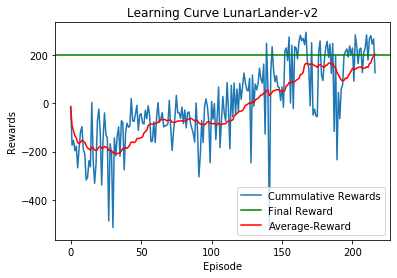

In [78]:
import matplotlib.pyplot as plt

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(crs)),crs,label = "Cummulative Rewards")
plt.axhline(y =200, xmin = 0, xmax = 250,color = 'g',label = "Final Reward")
plt.plot(average_reward,'r',label='Average-Reward')
plt.title('Learning Curve LunarLander-v2')
plt.ylabel('Rewards')
plt.xlabel('Episode')
plt.legend(loc='lower right')
plt.show()

## Saving Score Vectors:

In [79]:
np.savetxt('score32.csv',crs,delimiter=',') 
np.savetxt('avescore32.csv',average_reward,delimiter=',') 

## batch-size=64

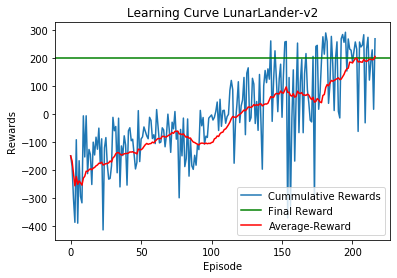

In [29]:
import matplotlib.pyplot as plt

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(crs)),crs,label = "Cummulative Rewards")
plt.axhline(y =200, xmin = 0, xmax = 250,color = 'g',label = "Final Reward")
plt.plot(average_reward,'r',label='Average-Reward')
plt.title('Learning Curve LunarLander-v2')
plt.ylabel('Rewards')
plt.xlabel('Episode')
plt.legend(loc='lower right')
plt.show()

## Saving Score Vectors:

In [31]:
np.savetxt('score64.csv',crs,delimiter=',') 
np.savetxt('avescore64.csv',average_reward,delimiter=',') 

## batch-size=128

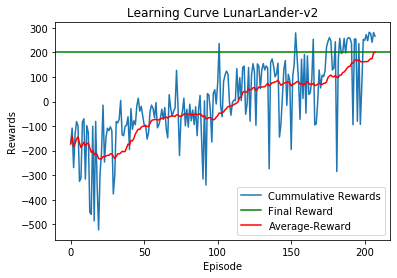

In [87]:
import matplotlib.pyplot as plt

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(crs)),crs,label = "Cummulative Rewards")
plt.axhline(y =200, xmin = 0, xmax = 250,color = 'g',label = "Final Reward")
plt.plot(average_reward,'r',label='Average-Reward')
plt.title('Learning Curve LunarLander-v2')
plt.ylabel('Rewards')
plt.xlabel('Episode')
plt.legend(loc='lower right')
plt.show()

## Saving Score Vectors:

In [88]:
np.savetxt('score128.csv',crs,delimiter=',') 
np.savetxt('avescore128.csv',average_reward,delimiter=',') 

# Visulizing The Performance

In [38]:
import time
import io
import base64
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

In [117]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_video_of_model(agent, env_name):
    env = gym.make(env_name)             
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    agent.value_net.load_state_dict(torch.load('checkpoint_mid_train2.pth',map_location={'cuda:0': 'cpu'}))
    state = env.reset()
    done = False
    while not done:
        frame = env.render()
        vid.capture_frame()
        
        action = agent.take_action(state)

        state, reward, done, _ = env.step(action)        
    env.close()

In [ ]:
agent = DQNAgent(state_size,action_size,batch_size=64,gamma=0.99,capacity=25000,alpha=5e-4,seed=0)
show_video_of_model(agent, 'LunarLander-v2')

In [42]:
show_video('LunarLander-v2')

# DDQN

In [104]:
# DDQN agent
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DDQNAgent():
    
    def __init__(self,state_size,action_size,batch_size,gamma,capacity,alpha,tau,seed):
        
        # network parameter
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau

        # experience replay
        self.experience_replay = ExperienceReplay(capacity,seed)

        # network
        self.value_net = DeepQNetwork(state_size,action_size,seed).to(device)
        self.target_value_net = DeepQNetwork(state_size, action_size,seed).to(device)
        self.update_target_network()
        
        self.optimizer = optim.Adam(self.value_net.parameters(),lr=alpha)              
            
    def take_action(self, state, eps=0.0):
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.value_net.eval()
        with torch.no_grad():
            action_values = self.value_net(state)
        self.value_net.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def update_params(self):
        if len(self.experience_replay) < self.batch_size:
            return

        # transition batch
        batch = Transition(*zip(self.experience_replay.sample(self.batch_size)))

        state_batch = torch.from_numpy(np.vstack(batch.state)).float().to(device)
        action_batch = torch.tensor(np.vstack(batch.action)).long().to(device)
        next_state_batch = torch.from_numpy(np.vstack(batch.next_state)).float().to(device)
        reward_batch = torch.tensor(np.vstack(batch.reward)).float().to(device)
        done_batch = torch.tensor(np.vstack(batch.done)).to(device)
        
        
        Q_target_av = self.value_net(next_state_batch).detach().max(1)[0].unsqueeze(1)
        Q_target = reward_batch + self.gamma*(Q_target_av)*(1-done_batch) 
        Q_expected = self.value_net(state_batch).gather(1, action_batch) 
        
        loss = F.mse_loss(Q_expected,Q_target)
        self.optimizer.zero_grad()
        loss.backward() 
        self.optimizer.step()   
        
    
    def update_target_network(self):
        # ------------------- update target network ------------------- #
        for target_param, local_param in zip(self.target_value_net.parameters(),self.value_net.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)
        

    def save(self, fname):
        
        torch.save(self.value_net.state_dict(),fname)     
        
        
    def load(self, fname, device):
      
        self.value_net.load_state_dict(torch.load(fname,map_location={'cuda:0': 'cpu'}))
        

In [105]:
# training phase
import time

agent_DDQN = DDQNAgent(state_size,action_size,batch_size=64,gamma=0.99,capacity=25000,alpha=5e-4,tau=1e-3,seed=0)

crs_DDQN = [] # cummulative rewards
crs_recent_DDQN = deque(maxlen=25) # recent cummulative rewards   
average_reward_DDQN=[]
# training loop

for i_episode in range(1, n_episodes+1):
        
  state = env.reset()
  cr_DDQN = 0
  done=0  
  while not done:
    action = agent_DDQN.take_action(state, eps)
    next_state, reward, done,_  = env.step(action)
    agent_DDQN.experience_replay.store_trans(state,action,next_state,reward,done)
    agent_DDQN.update_params()
    state = next_state
    cr_DDQN += reward
  
  crs_recent_DDQN.append(cr_DDQN)       # save most recent score
  average_reward_DDQN.append(np.mean(crs_recent_DDQN))
  crs_DDQN.append(cr_DDQN)              # save most recent score
  eps = max(eps_end,eps_decay_rate*eps) # decrease epsilon
  print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent_DDQN), eps), end="")
    
  if i_episode == 50:
    agent_DDQN.save('checkpoint_mid_train1.pth')
  if i_episode == 100:
    agent_DDQN.save('checkpoint_mid_train2.pth')
  if i_episode == 150:
    agent_DDQN.save('checkpoint_mid_train3.pth')
  if i_episode == 200:
    agent_DDQN.save('checkpoint_mid_train4.pth')
  if i_episode == 250:
    agent_DDQN.save('checkpoint_mid_train5.pth')
    
  if i_episode % 25 == 0:
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent_DDQN), eps))
    
  if np.mean(crs_recent_DDQN)>=200.0:
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(crs_recent_DDQN)))
    agent_DDQN.save('final_checkpoint.pth')
    break

Episode 25	Average Reward: -178.60	Epsilon: 0.78
Episode 50	Average Reward: -87.46	Epsilon: 0.616
Episode 75	Average Reward: -74.75	Epsilon: 0.47
Episode 100	Average Reward: -43.69	Epsilon: 0.37
Episode 125	Average Reward: 46.12	Epsilon: 0.282
Episode 150	Average Reward: 49.82	Epsilon: 0.22
Episode 175	Average Reward: 32.01	Epsilon: 0.17
Episode 200	Average Reward: 115.85	Epsilon: 0.13
Episode 221	Average Reward: 207.75	Epsilon: 0.11
Environment solved in 221 episodes!	Average Score: 207.75


In [106]:
crs=np.loadtxt('score64.csv') 
average_reward=np.loadtxt('avescore64.csv') 

## batch-size=64

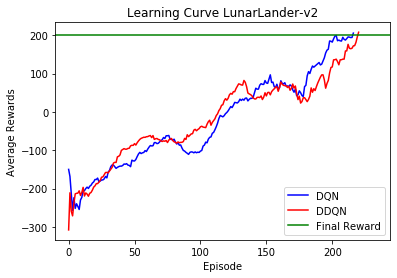

In [107]:
import matplotlib.pyplot as plt

# plot the scores

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(average_reward,'b',label='DQN')
plt.plot(average_reward_DDQN,'r',label='DDQN')
plt.axhline(y =200, xmin = 0, xmax = 250,color = 'g',label = "Final Reward")
plt.title('Learning Curve LunarLander-v2')
plt.ylabel('Average Rewards')
plt.xlabel('Episode')
plt.legend()
plt.xlim([-10,244])
plt.show()

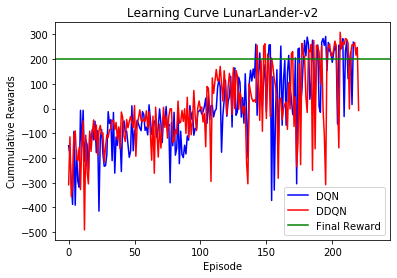

In [110]:
import matplotlib.pyplot as plt

# plot the scores

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(crs,'b',label='DQN')
plt.plot(crs_DDQN,'r',label='DDQN')
plt.axhline(y =200, xmin = 0, xmax = 250,color = 'g',label = "Final Reward")
plt.title('Learning Curve LunarLander-v2')
plt.ylabel('Cummulative Rewards')
plt.xlabel('Episode')
plt.legend()
plt.xlim([-10,244])
plt.show()

## Saving Score Vectors:

In [108]:
np.savetxt('score64_DDQN.csv',crs_DDQN,delimiter=',') 
np.savetxt('avescore64_DDQN.csv',average_reward_DDQN,delimiter=',') 

# Visulizing The Performance

In [118]:
agent_DDQN = DDQNAgent(state_size,action_size,batch_size=64,gamma=0.99,capacity=25000,alpha=5e-4,tau=1e-3,seed=0)
show_video_of_model(agent_DDQN,'LunarLander-v2')

In [116]:
show_video('LunarLander-v2')